# Import Libraries

Zuerst binden wir wie immer die Benutzen Bibliotheken ein.

In [79]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
from scipy.linalg import block_diag
import time


import matplotlib.pyplot as plt

Unterliegender Block wird noch in eigene Library gepackt

In [97]:
def gen_rand_mat(eig, compl = False):
    n = eig.shape[0]
    if compl:
        B = np.random.rand(n,n) + np.random.rand(n,n)*compl*1j
    else:
        B = np.random.rand(n,n)
    return np.linalg.inv(B)@np.diag(eig)@B



def error(eig_1, eig_2):
    return np.linalg.norm(eig_1 - eig_2)

def runtime(f, A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start

def runtime_error(f,A, eigv):
    start = time.time()
    S = f(A)[1]
    S = error(S, eigv)
    end = time.time()
    return end - start, S

def generate_rand_eigvals(n):
    return np.sort(5000*np.random.rand(n)-25)

def QR_hesse(A,tol=1e-12):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        a = np.random.rand(n)
        b = np.random.rand(n-1)
        c = np.random.rand(n-1)
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)

# Implemented QR-Algorithm

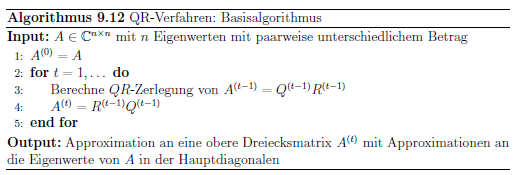


Diese simple Version ist schnell implementiert. Zur Fehler- und Laufzeittestung kommen wir am Ende des Abschnitts.

In [81]:
def QR_simple(A,tol = 1e-6):  #Toleranz wird auf Standardwert gesetzt, falls im Aufruf nicht anders angegeben
    n = A.shape[1]
    count = 0
    while max([abs(A[i,i-1]) for i in range(1,n)]) > tol:   #Abbruchbedingung, in dieser Implementation auch Aufwändig
        Q,R = np.linalg.qr(A)  #Für die QR-Zerlegung wurde eine Funktion aus dem Numpy-Linalg Paket verwendet
        A = R@Q                #Der wesentliche Schritt
        count +=1              
    return A, sorted(np.diag(A)), count

Hier Algorithmus Header Einfügen

In [82]:
def QR_shift(A,tol=1e-10):
    n = A.shape[1]                                    #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            rho = A[i,i]                              #Der Shift-Parameter
            Q,R = np.linalg.qr(A-rho*np.identity(n))  #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)              #RQ + Rückshift
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

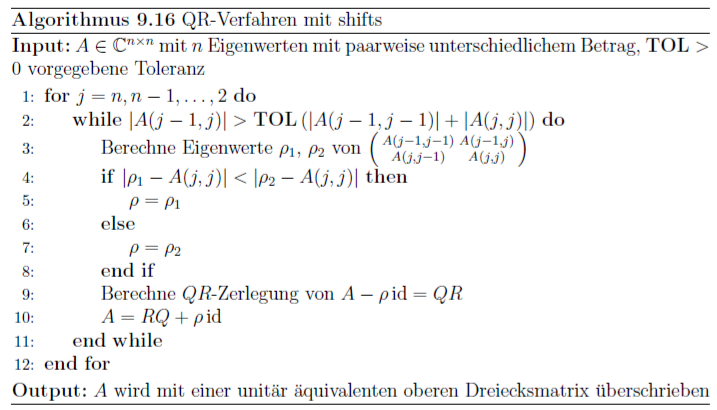

Die effizienteste Wahl des Shifts

In [83]:
def QR_shift2(A,tol=1e-12):
    n = A.shape[1]                                                #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                                     #i durchläuft {1,...,n} rückwärts
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):  #Hier ein kleiner Fehler im Skript
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])             #Eigenwerte werden berechnet
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

In [103]:
n_arr = [10*i for i in range(1,30)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250)) #Eigenwerte werden zufällig generiert

In [104]:
mat_array = []

for i in range(k):
    mat_array.append(gen_rand_mat(eigv_array[i]))

In [105]:
time_1 = [0]*k
time_2 = [0]*k
time_3 = [0]*k

error_1 = [0]*k
error_2 = [0]*k
error_3 = [0]*k
for i in range(k):
    #time_1[i], error_1[i] = runtime_error(QR_simple, mat_array[i], eigv_array[i])
    time_2[i], error_2[i] = runtime_error(QR_shift, mat_array[i], eigv_array[i])
    time_3[i], error_3[i] = runtime_error(QR_shift2, mat_array[i], eigv_array[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


<IPython.core.display.Javascript object>


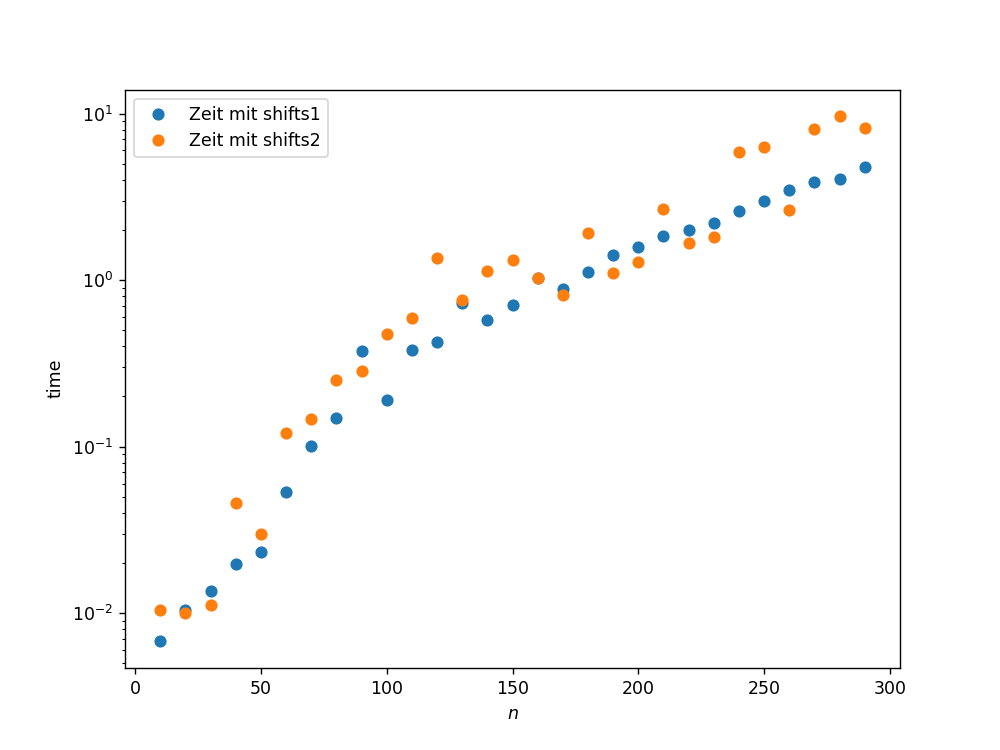

In [106]:
%matplotlib notebook

#plt.semilogy(n_arr, time_1, 'o', label = "Zeit ohne shifts")
plt.semilogy(n_arr, time_2, 'o', label = "Zeit mit shifts1")
plt.semilogy(n_arr, time_3, 'o', label = "Zeit mit shifts2")

plt.ylabel("time")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


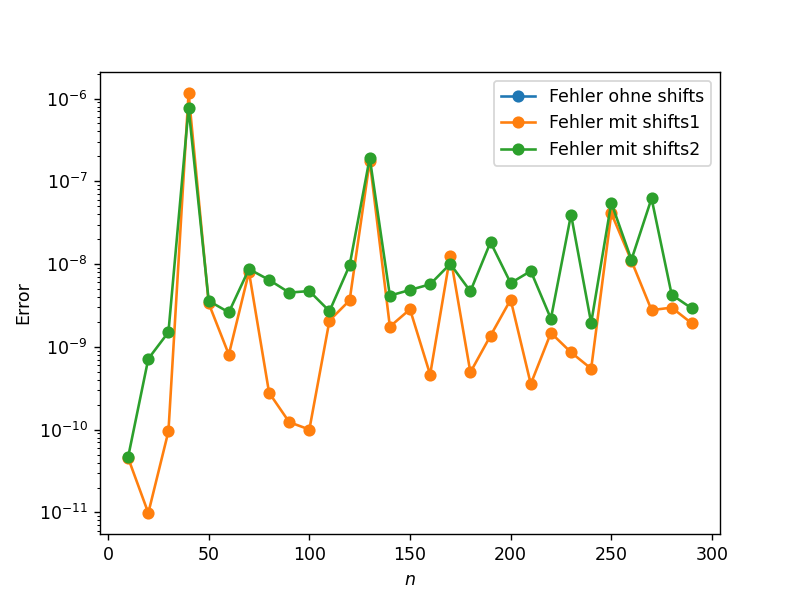

In [108]:
%matplotlib notebook

plt.semilogy(n_arr, error_1, '-o', label = "Fehler ohne shifts")
plt.semilogy(n_arr, error_2, '-o', label = "Fehler mit shifts1")
plt.semilogy(n_arr, error_3, '-o', label = "Fehler mit shifts2")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

## Special-Case: QR-Algorithm applied to a Hessian-Matrix

Hier können wir Givens-Rotation verwenden um die QR-Zerlegung durchzufühern und einen speed-up zu bekommen.

In [98]:
def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
            
        M = np.array([[c.conj(), s.conj()], [-s, c]])
        G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2))
        Q = G@Q
        for j in range(i, n):
            temp_1 = A[i,j]
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]
    return Q.T.conj(), A

Wir können nun auch Vergleichen.

In [109]:
n_arr = [10*i for i in range(1,13)]                                 #Dimension des Problems

k = len(n_arr)
    
mat_array = []

for i in range(k):
    mat_array.append(gen_hess(n_arr[i])) #Hesseberg-Matrizen der Dimension n werden erstellt

In [110]:
time_1 = [0]*k
time_2 = [0]*k

for i in range(k):
    time_1[i] = runtime(QR_hesse, mat_array[i])
    time_2[i] = runtime(QR_shift2, mat_array[i])

<IPython.core.display.Javascript object>


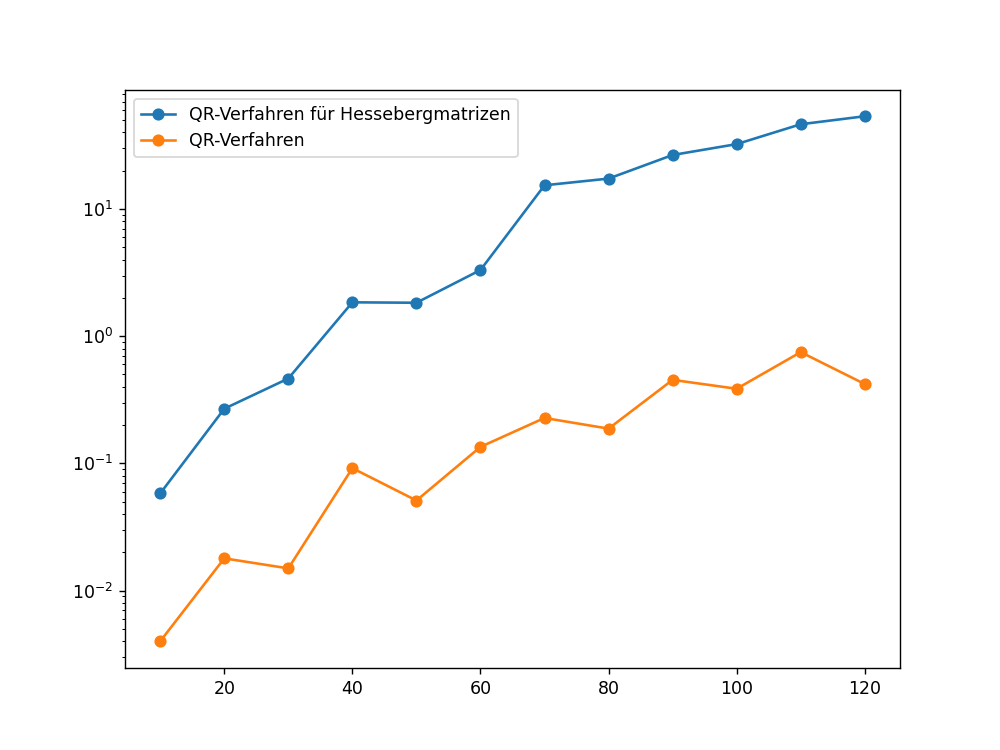

In [111]:
%matplotlib notebook

plt.semilogy(n_arr, time_1, '-o', label = "QR-Verfahren für Hessebergmatrizen")
plt.semilogy(n_arr, time_2, '-o', label = "QR-Verfahren")

plt.legend()
plt.show()

Wie man erkennt ist der Vorimplementierte QR-Algorithmus wohl immer noch effizienter.

## Lanczos-Algorithm and its shortcomings

To be continued...